In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from preprocess import *
from add_features import *
from models import *
sns.set(style="whitegrid")  # nice background for plots


warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)        # Afficher toutes les lignes
pd.set_option('display.max_columns', None)  



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df_champs=pd.read_csv("data/Av_Champs_Elysees.csv", sep=";")

In [15]:
df_champs['Débit horaire']

0        259.0
1        330.0
2        618.0
3       1018.0
4       1275.0
5       1284.0
6       1111.0
7       1062.0
8       1157.0
9       1104.0
10      1181.0
11      1207.0
12      1156.0
13      1302.0
14      1360.0
15      1253.0
16      1039.0
17       860.0
18       707.0
19       675.0
20       661.0
21       511.0
22       363.0
23       243.0
24       210.0
25       306.0
26       617.0
27      1131.0
28      1392.0
29      1374.0
30      1293.0
31      1282.0
32      1300.0
33      1219.0
34      1242.0
35      1253.0
36      1117.0
37      1223.0
38      1329.0
39      1287.0
40       915.0
41       849.0
42       870.0
43       903.0
44       846.0
45       572.0
46       458.0
47       307.0
48       260.0
49       333.0
50       537.0
51       696.0
52       940.0
53      1074.0
54      1208.0
55      1264.0
56      1143.0
57      1094.0
58      1076.0
59      1081.0
60      1185.0
61      1180.0
62      1265.0
63      1124.0
64      1180.0
65       928.0
66       7

In [11]:
def pipeline(df_champs):
    df_champs=order_by_date(df_champs)
    
    df_champs = create_datetime_features(df_champs)
    
    df_champs=vacances_by_zone(df_champs)

    df_champs = add_school_holidays_paris(df_champs)

    df_champs=create_holidays(df_champs)
    
    df_champs['day_type'] = df_champs.apply(day_type, axis=1)

    df_champs = add_cyclic_features(df_champs)
    
    #df_champs=fill_nan(df_champs)
    df_champs = df_champs[(df_champs["Débit horaire"].notna()) &
    (df_champs["Taux d'occupation"].notna())
]
    
    df_champs=merge_meteo(df_champs)
    
    targets = ['Débit horaire', "Taux d'occupation"]

    special_events_dict = {
        '2025-02-02': 'course',
        '2025-07-02': 'ceremonie',
        '2024-12-31': 'nouvel_an',
        '2024-11-11': 'armistice',
        '2025-07-14': 'fete_nationale'
    }

    df_champs = mark_outliers_and_special_events(df_champs, targets, special_events_dict, top_n=20)

    #df_champs = add_trafic_flow_around(df_champs,"data\comptages-routiers-permanents(5).csv")

    return(df_champs)

df_champs=pipeline(df_champs)


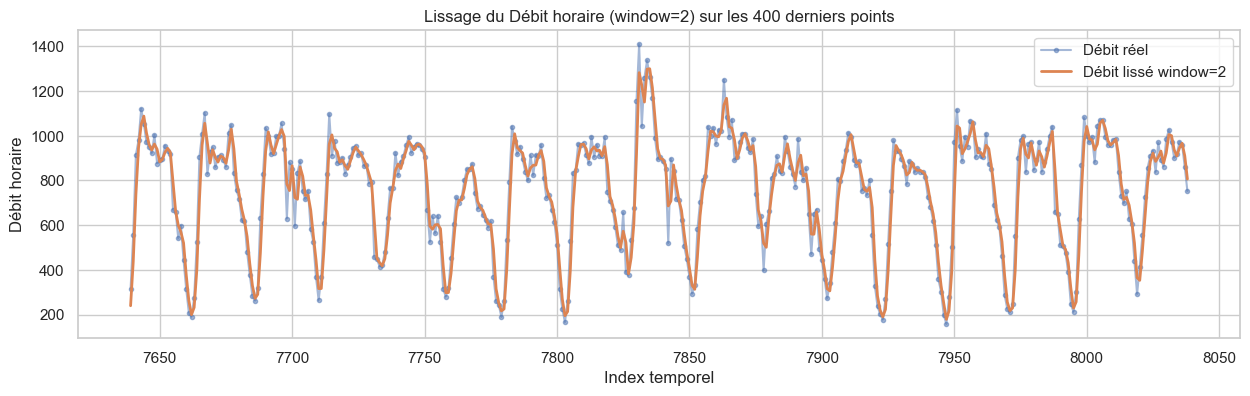

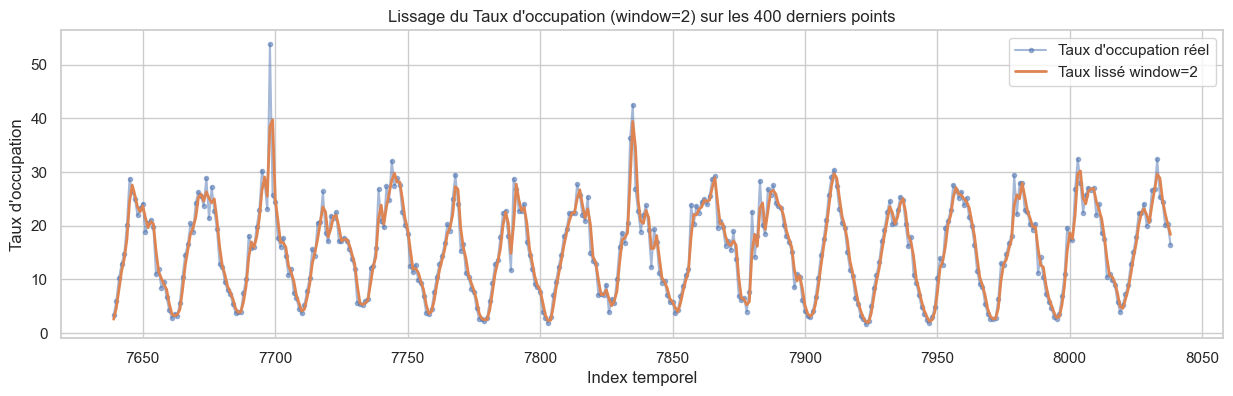

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres
window = 2
n_plot = 400  # nombre de points à visualiser

# Créer un nouveau dataframe lissé
df_lisse = df_champs.copy()

# Appliquer le lissage sur les targets sans changer leur nom
for target in ['Débit horaire', "Taux d'occupation"]:
    df_lisse[target] = df_lisse[target].rolling(window=window, center=True, min_periods=1).mean()
    df_lisse[target].fillna(df_champs[target], inplace=True)  # remplir les NaN éventuels

# --- Plot Débit horaire ---
plt.figure(figsize=(15, 4))
plt.plot(df_champs['Débit horaire'].iloc[-n_plot:], label='Débit réel', alpha=0.5, marker='o', markersize=3)
plt.plot(df_lisse['Débit horaire'].iloc[-n_plot:], label=f'Débit lissé window={window}', linewidth=2)
plt.title(f"Lissage du Débit horaire (window={window}) sur les {n_plot} derniers points")
plt.xlabel("Index temporel")
plt.ylabel("Débit horaire")
plt.legend()
plt.show()

# --- Plot Taux d'occupation ---
plt.figure(figsize=(15, 4))
plt.plot(df_champs["Taux d'occupation"].iloc[-n_plot:], label="Taux d'occupation réel", alpha=0.5, marker='o', markersize=3)
plt.plot(df_lisse["Taux d'occupation"].iloc[-n_plot:], label=f"Taux lissé window={window}", linewidth=2)
plt.title(f"Lissage du Taux d'occupation (window={window}) sur les {n_plot} derniers points")
plt.xlabel("Index temporel")
plt.ylabel("Taux d'occupation")
plt.legend()
plt.show()


# LSTM 2 Targets sur 24H

In [34]:
targets = ['Débit horaire', "Taux d'occupation"]
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
    #,'Débit horaire_around','Taux d\'occupation_around'
]

In [ ]:
df_champs[features]

Epoch 0: Train Loss=0.06989, Val Loss=0.00679
Epoch 5: Train Loss=0.00961, Val Loss=0.00424
Epoch 10: Train Loss=0.00616, Val Loss=0.00384
Epoch 15: Train Loss=0.00493, Val Loss=0.00380
✅ Débit horaire: RMSE=101.55, Moyenne=734.09, Erreur relative=13.83%
✅ Taux d'occupation: RMSE=4.02, Moyenne=15.86, Erreur relative=25.32%


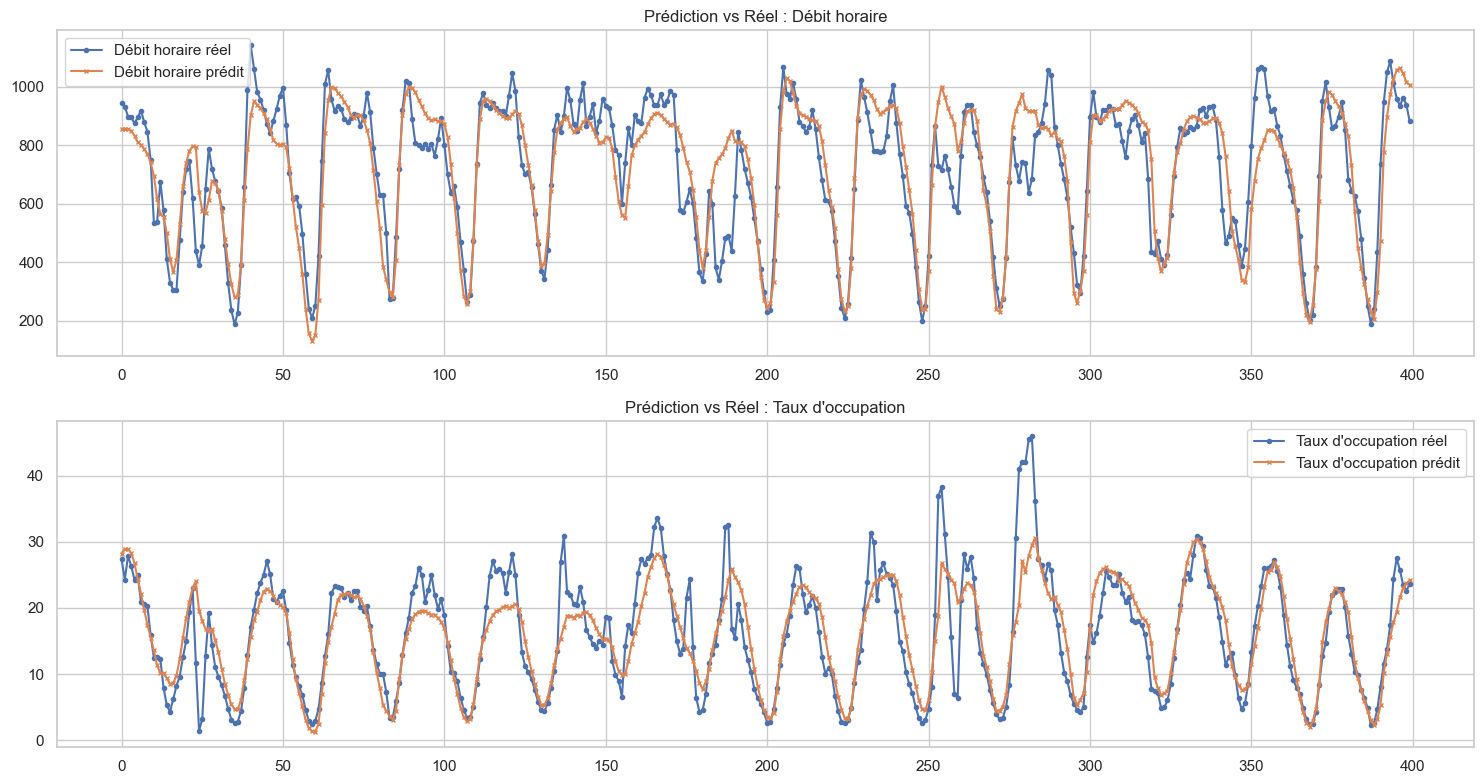

In [36]:
# --- Imports ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# --- 1. Dataset pour N-BEATS ---
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- 2. Préparation des données (comme ton LSTM, mais pour PyTorch) ---
def prepare_data_nbeats(df, features, targets, seq_length=168):
    df_model = df.copy()
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(df_model[features + targets])
    y_scaled = scaler_y.fit_transform(df_model[targets])
    
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X_scaled)):
        X_seq.append(X_scaled[i-seq_length:i])
        y_seq.append(y_scaled[i])
        
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    # Split temporel train/test
    train_size = int(len(X_seq) * 0.9)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]
    
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    
    return train_dataset, test_dataset, scaler_X, scaler_y

# --- 3. Définition d'un N-BEATS simple ---
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, nb_layers=3):
        super().__init__()
        layers = []
        for _ in range(nb_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        # x shape = (batch, seq_length, n_features)
        x = x.reshape(x.size(0), -1)  # flatten sequence
        return self.block(x)

class NBeatsModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, nb_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([NBeatsBlock(input_size, output_size, hidden_size) for _ in range(nb_blocks)])
        
    def forward(self, x):
        out = 0
        for block in self.blocks:
            out += block(x)
        return out

# --- 4. Entraînement ---
def train_nbeats(model, train_loader, test_loader, lr=1e-3, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        
        # Evaluation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(test_loader.dataset)
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Train Loss={train_loss:.5f}, Val Loss={val_loss:.5f}")
    return model

# --- 5. Évaluation et plot ---
def evaluate_nbeats(model, test_loader, scaler_y, targets):
    model.eval()
    y_preds, y_trues = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch).numpy()
            y_preds.append(y_pred)
            y_trues.append(y_batch.numpy())
    y_pred = np.vstack(y_preds)
    y_true = np.vstack(y_trues)
    
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_true_inv = scaler_y.inverse_transform(y_true)
    
    for i, t in enumerate(targets):
        rmse = np.sqrt(mean_squared_error(y_true_inv[:, i], y_pred_inv[:, i]))
        mean_val = np.mean(y_true_inv[:, i])
        print(f"✅ {t}: RMSE={rmse:.2f}, Moyenne={mean_val:.2f}, Erreur relative={rmse/mean_val*100:.2f}%")
    
    return y_true_inv, y_pred_inv

def plot_predictions_nbeats(y_true, y_pred, targets, n_plot=400):
    if n_plot is not None:
        y_true = y_true[:n_plot]
        y_pred = y_pred[:n_plot]
    
    plt.figure(figsize=(15, 8))
    for i, t in enumerate(targets):
        plt.subplot(len(targets), 1, i+1)
        plt.plot(y_true[:, i], label=f"{t} réel", marker='o', markersize=3)
        plt.plot(y_pred[:, i], label=f"{t} prédit", marker='x', markersize=3)
        plt.title(f"Prédiction vs Réel : {t}")
        plt.legend()
    plt.tight_layout()
    plt.show()

# --- 6. Exemple d'utilisation ---
seq_length = 168  # 1 semaine d'historique
batch_size = 32

train_dataset, test_dataset, scaler_X, scaler_y = prepare_data_nbeats(df_lisse, features, targets, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = seq_length * len(features + targets)
output_size = len(targets)

model = NBeatsModel(input_size, output_size, hidden_size=128, nb_blocks=3)
model = train_nbeats(model, train_loader, test_loader, lr=1e-3, epochs=20)

y_true_inv, y_pred_inv = evaluate_nbeats(model, test_loader, scaler_y, targets)
plot_predictions_nbeats(y_true_inv, y_pred_inv, targets)


Epoch 1/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0226 - val_loss: 0.0075
Epoch 2/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0110 - val_loss: 0.0049
Epoch 3/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0089 - val_loss: 0.0045
Epoch 4/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0076 - val_loss: 0.0041
Epoch 5/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 6/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 7/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 8/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 9/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 10/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 11/20
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 12/20
222/222 ━━━━━━━━━━━━━━━━━━━

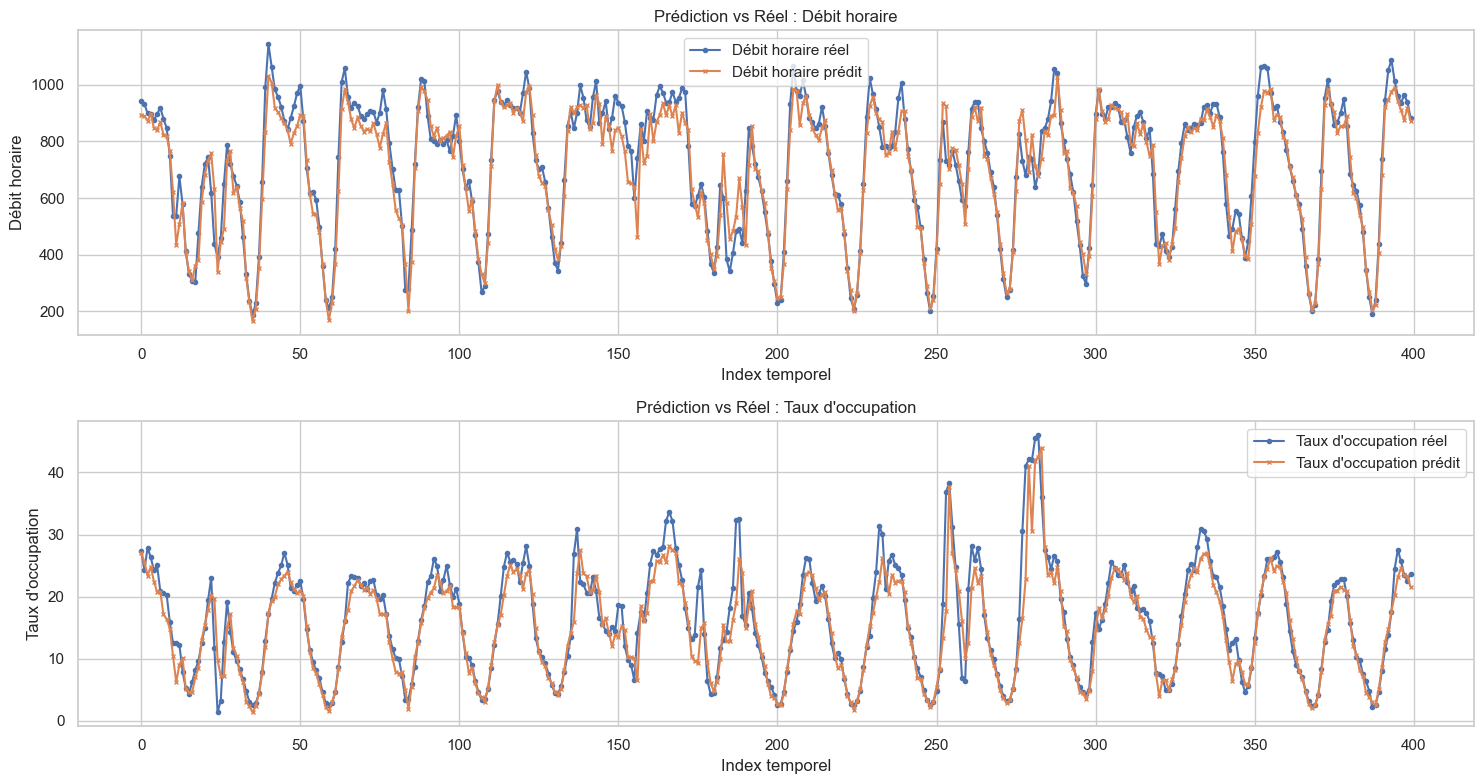

In [42]:
# Définition des targets et features
targets = ['Débit horaire', "Taux d'occupation"]
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
    #,'Débit horaire_around', 'Taux d\'occupation_around'
]

# 1. Préparer les données
X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_data(df_lisse, features, targets, seq_length=168)

# 2. Entraîner le modèle
model, history = train_lstm_24(X_train, y_train, X_test, y_test, lstm_units=64, dropout=0.2, epochs=20, batch_size=32)

# 3. Évaluer le modèle
y_test_inv, y_pred_inv = evaluate_model(model, X_test, y_test, scaler_y, targets)

# 4. Plot des prédictions
plot_predictions(y_test_inv, y_pred_inv, targets, n_plot=400) 

In [45]:
from sklearn.metrics import mean_absolute_percentage_error
for i, t in enumerate(targets):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    mape = mean_absolute_percentage_error(y_test_inv[:, i], y_pred_inv[:, i])
    print(f"MAPE = {mape:.2f}")
    mean_val = np.mean(y_test_inv[:, i])
    print(f"✅ {t} : RMSE = {rmse:.2f}, Moyenne = {mean_val:.2f}, Erreur relative = {rmse/mean_val*100:.2f}%")

MAPE = 0.07
✅ Débit horaire : RMSE = 68.08, Moyenne = 734.09, Erreur relative = 9.27%
MAPE = 0.13
✅ Taux d'occupation : RMSE = 2.78, Moyenne = 15.86, Erreur relative = 17.55%


In [165]:
import pandas as pd

# S'assurer que la colonne date est en datetime
df_champs['date'] = pd.to_datetime(df_champs['date'])

# Dates à filtrer
dates_to_check = ['2024-11-11', '2025-07-14']

# Filtrer
filtered_dates = df_champs[df_champs['date'].dt.strftime('%Y-%m-%d').isin(dates_to_check)]

# Afficher les colonnes d'intérêt
display(filtered_dates[['date', 'hour', 'Débit horaire', "Taux d'occupation"]])


,date,hour,Débit horaire,Taux d'occupation
980,2024-11-11,0,825.000000,15.398340
981,2024-11-11,1,755.000000,11.887780
982,2024-11-11,2,680.000000,8.979450
983,2024-11-11,3,406.000000,4.965000
984,2024-11-11,4,269.000000,2.698340
985,2024-11-11,5,273.000000,6.171110
986,2024-11-11,6,317.000000,3.441670
987,2024-11-11,7,217.000000,2.250000
988,2024-11-11,8,74.000000,0.897220
989,2024-11-11,9,53.000000,0.430560



Débit horaire : 2 valeurs aberrantes


,date,hour,Débit horaire
2446,2025-02-02,11,2190.0
5981,2025-07-02,17,1587.0


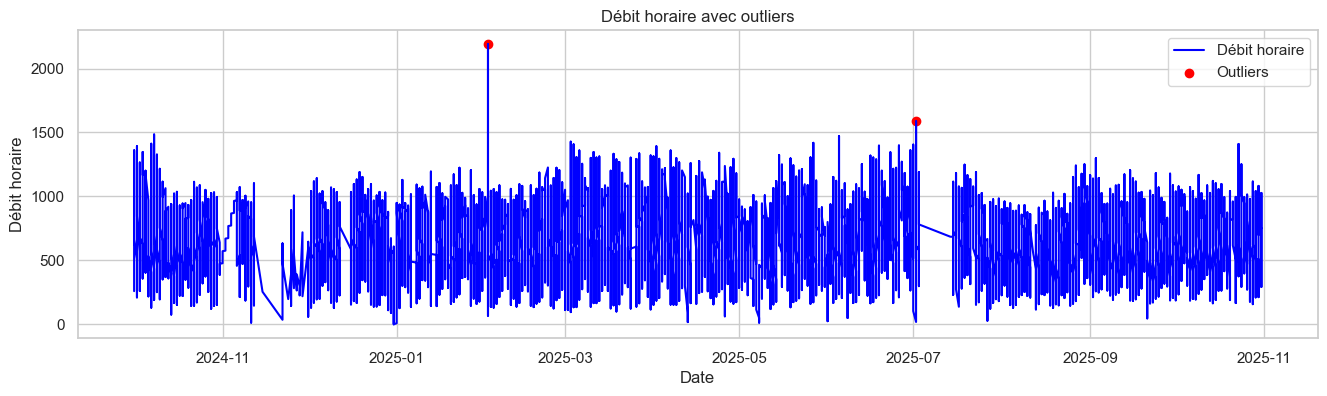


Taux d'occupation : 96 valeurs aberrantes


,date,hour,Taux d'occupation
1298,2024-12-11,15,66.403890
1317,2024-12-12,10,60.820560
1319,2024-12-12,12,55.766110
1320,2024-12-12,13,52.722230
1321,2024-12-12,14,52.535560
1322,2024-12-12,15,53.183890
1323,2024-12-12,16,50.250560
1324,2024-12-12,17,49.803359
1325,2024-12-12,18,49.356157
1326,2024-12-12,19,48.908956


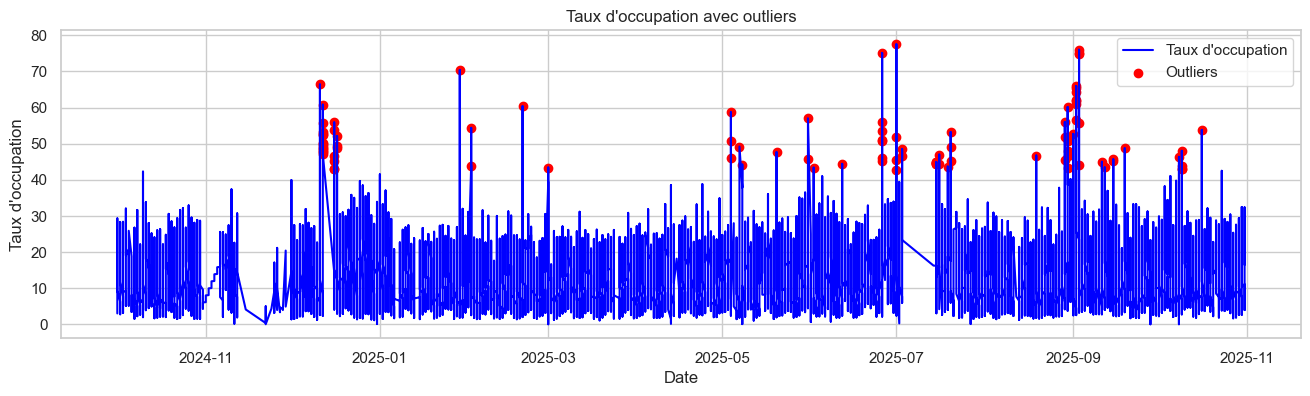

In [ ]:
import matplotlib.pyplot as plt

targets = ['Débit horaire', "Taux d'occupation"]

outliers_info = {}

for t in targets:
    Q1 = df_champs[t].quantile(0.25)
    Q3 = df_champs[t].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Filtrer les outliers
    outliers = df_champs[(df_champs[t] < lower) | (df_champs[t] > upper)]
    
    # Récupérer date et heure
    outliers_info[t] = outliers[['date', 'hour', t]]
    print(f"\n{t} : {len(outliers)} valeurs aberrantes")
    display(outliers_info[t].head(10))  # affiche les 10 premiers

    # Plot
    plt.figure(figsize=(16,4))
    plt.plot(df_champs['date'], df_champs[t], label=t, color='blue')
    plt.scatter(outliers['date'], outliers[t], color='red', label='Outliers')
    plt.title(f"{t} avec outliers")
    plt.xlabel("Date")
    plt.ylabel(t)
    plt.legend()
    plt.show()




=== Analyse des outliers pour : Débit horaire ===
⚠️ Outliers détectés (hauts et bas) :
           date  hour  Débit horaire
2446 2025-02-02    11         2190.0
5981 2025-07-02    17         1587.0
1713 2024-12-31    22            0.0
1714 2024-12-31    23            0.0
1712 2024-12-31    21            1.0
1711 2024-12-31    20            2.0
1715 2025-01-01     0            8.0
990  2024-11-11    10           13.0
4669 2025-05-08    18           13.0
4668 2025-05-08    17           15.0
4093 2025-04-13     2           17.0
5964 2025-07-02     0           18.0
1708 2024-12-31    17           24.0
5236 2025-06-01    16           24.0
991  2024-11-11    11           26.0
4097 2025-04-13     6           26.0
4095 2025-04-13     4           27.0
6313 2025-07-27    13           28.0
5965 2025-07-02     1           29.0
5234 2025-06-01    14           32.0
4667 2025-05-08    16           33.0
4094 2025-04-13     3           34.0


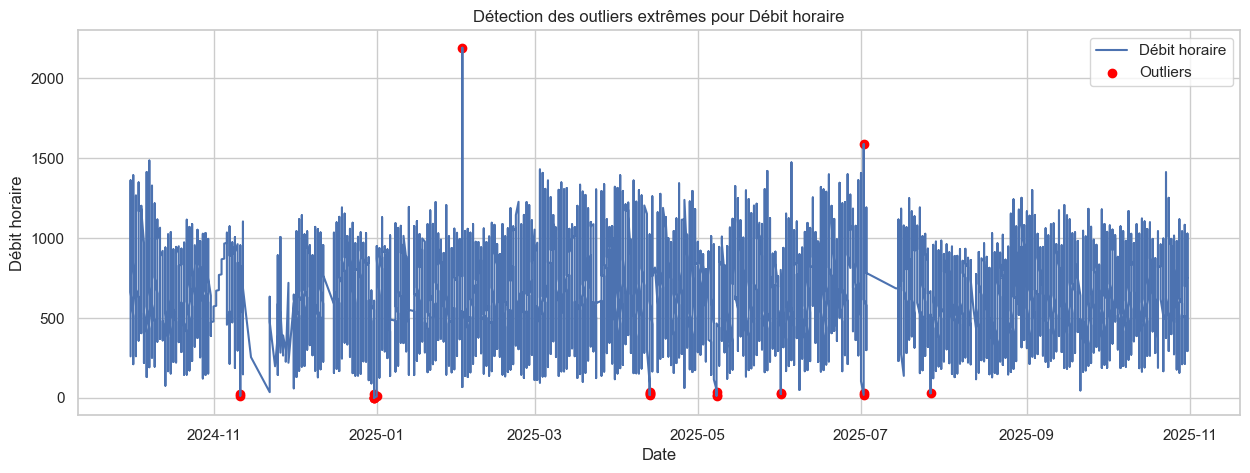


=== Analyse des outliers pour : Taux d'occupation ===
⚠️ Outliers détectés (hauts et bas) :
           date  hour  Taux d'occupation
1298 2024-12-11    15          66.403890
1317 2024-12-12    10          60.820560
1319 2024-12-12    12          55.766110
1320 2024-12-12    13          52.722230
1321 2024-12-12    14          52.535560
1322 2024-12-12    15          53.183890
1323 2024-12-12    16          50.250560
1324 2024-12-12    17          49.803359
1325 2024-12-12    18          49.356157
1326 2024-12-12    19          48.908956
1327 2024-12-12    20          48.461754
1328 2024-12-12    21          48.014553
1329 2024-12-12    22          47.567352
1330 2024-12-12    23          47.120150
1343 2024-12-16    12          55.886110
1344 2024-12-16    13          53.796670
1345 2024-12-16    14          46.523340
1346 2024-12-16    15          45.232780
1349 2024-12-16    18          42.994450
1350 2024-12-16    19          43.037220
1365 2024-12-17    10          49.406670
1367 

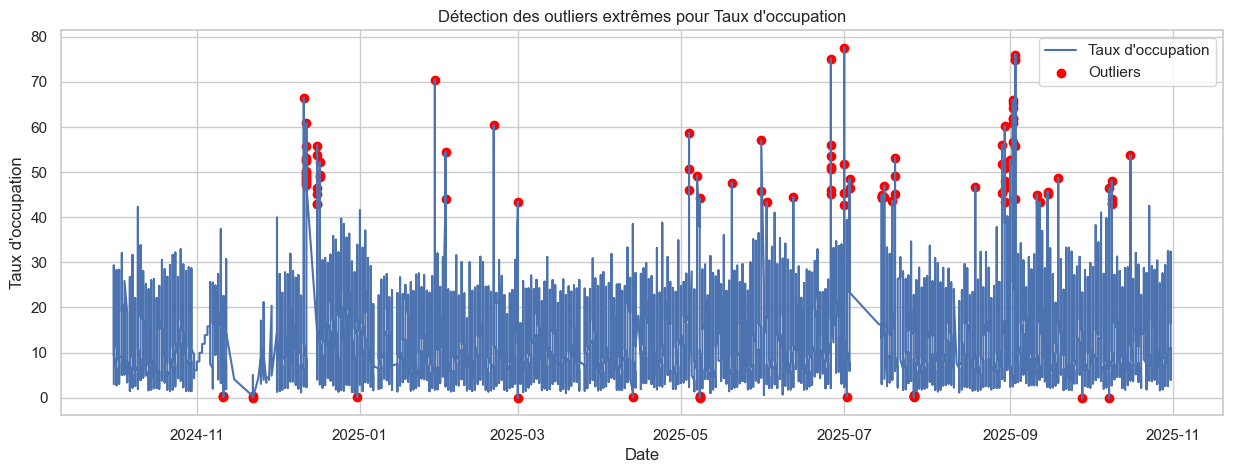

In [ ]:
import matplotlib.pyplot as plt

targets = ['Débit horaire', "Taux d'occupation"]

for target in targets:
    print(f"\n=== Analyse des outliers pour : {target} ===")
    
    # Détection des outliers hauts avec IQR
    q1 = df_champs[target].quantile(0.25)
    q3 = df_champs[target].quantile(0.75)
    iqr = q3 - q1

    upper_bound = q3 + 1.5 * iqr
    high_outliers = df_champs[df_champs[target] > upper_bound]

    # Détection des valeurs très basses : les 20 plus petites
    low_outliers = df_champs.nsmallest(20, target)

    # Concaténation pour affichage
    all_outliers = pd.concat([high_outliers, low_outliers]).drop_duplicates()

    # Affichage des dates et heures des outliers
    print("⚠️ Outliers détectés (hauts et bas) :")
    print(all_outliers[['date', 'hour', target]])

    # Plot
    plt.figure(figsize=(15,5))
    plt.plot(df_champs['date'], df_champs[target], label=target)
    plt.scatter(all_outliers['date'], all_outliers[target], color='red', label='Outliers')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'Détection des outliers extrêmes pour {target}')
    plt.legend()
    plt.show()


# LSTM 72h

Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0152 - val_loss: 0.0077
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0096 - val_loss: 0.0049
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0085 - val_loss: 0.0045
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0081 - val_loss: 0.0044
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0079 - val_loss: 0.0044
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0078 - val_loss: 0.0043
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0077 - val_loss: 0.0042
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 9/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 10/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 11/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 12/15
220/220 ━━━━━━━━━━━━━━━━━━━━

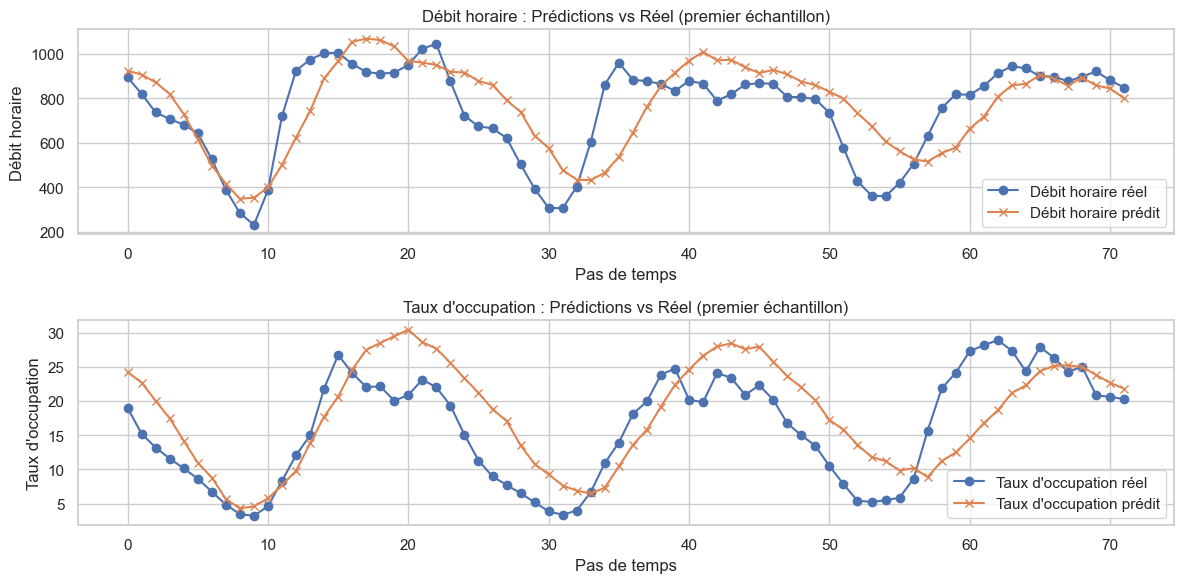

In [37]:
# 🔹 Appel du training
model, history, scaler_X, scalers_y, X_test, y_test = train_lstm_seq2seq(
    df=df_lisse,
    features=features,
    targets=targets,
    seq_length=168,
    pred_length=72,
    epochs=15,
    batch_size=32,
    log_transform=False
)
# 2️⃣ Évaluation et plot des prédictions
y_test_inv, y_pred_inv = evaluate_lstm_seq2seq(model, X_test, y_test, scalers_y, targets, n_plot=72)


In [67]:
y_test_inv.shape


(440, 72, 2)

In [66]:
y_pred_inv.shape

(440, 72, 2)

In [68]:
from sklearn.metrics import r2_score
for i, t in enumerate(targets):
        # Sélection des 72 premières valeurs
        y_true = y_test_inv[:72, :, i].flatten()
        y_pred = y_pred_inv[:72, :, i].flatten()
        r2 = r2_score(y_true, y_pred)
        print("R² :", r2)


R² : 0.7746167992764896
R² : 0.4150041193718831


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
âœ… Débit horaire : RMSE = 99.77, Moyenne = 405.12, Erreur relative = 24.63%
âœ… Taux d'occupation : RMSE = 3.38, Moyenne = 4.23, Erreur relative = 79.85%
âœ… Débit horaire : RMSE = 105.08, Moyenne = 403.89, Erreur relative = 26.02%
âœ… Taux d'occupation : RMSE = 2.70, Moyenne = 3.97, Erreur relative = 67.95%


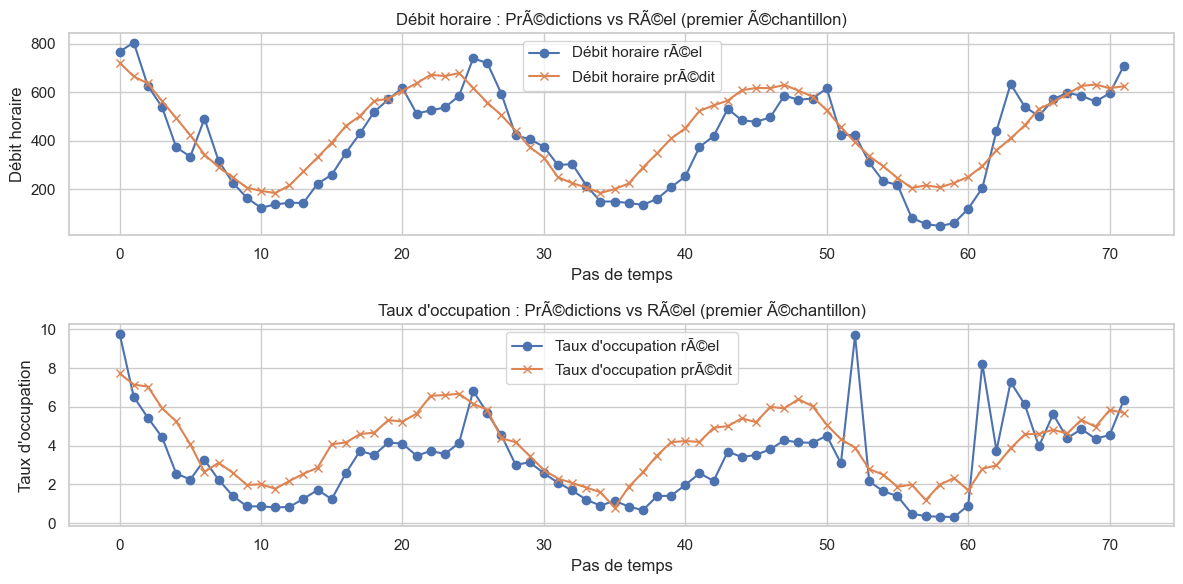

In [60]:
y_test_inv, y_pred_inv = evaluate_lstm_seq2seq(model, X_test, y_test, scalers_y, targets, n_plot=72)

In [48]:
# Calcul métriques par target
for i, t in enumerate(targets):
    # Sélection des 72 premières valeurs
    y_true = y_test_inv[:72, :, i].flatten()
    y_pred = y_pred_inv[:72, :, i].flatten()

    # Calcul des métriques
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_val = np.mean(y_true)
    print(f"✅ {t} : RMSE = {rmse:.2f}, Moyenne = {mean_val:.2f}, Erreur relative = {rmse/mean_val*100:.2f}%")

✅ Débit horaire : RMSE = 105.89, Moyenne = 403.89, Erreur relative = 26.22%
✅ Taux d'occupation : RMSE = 2.70, Moyenne = 3.97, Erreur relative = 68.05%


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_gradients_seq2seq(model, X_sample, pred_length=None, n_targets=None):
    """
    Calcule le gradient de chaque sortie par rapport aux entrées (Integrated Gradients simplifié)
    pour un modèle LSTM seq2seq Keras.

    Args:
        model : modèle Keras seq2seq (X -> Y)
        X_sample : np.array ou tf.Tensor, shape (1, seq_length, n_features)
        pred_length : int, nombre de pas de sortie à calculer (par défaut tous)
        n_targets : int, nombre de targets (par défaut tous)

    Returns:
        gradients : np.array de shape (pred_length, n_targets, seq_length, n_features)
    """
    X_sample = tf.convert_to_tensor(X_sample, dtype=tf.float32)
    seq_length = X_sample.shape[1]
    n_features = X_sample.shape[2]

    # Prédiction pour déterminer shape
    y_pred = model(X_sample)
    if pred_length is None:
        pred_length = y_pred.shape[1]
    if n_targets is None:
        n_targets = y_pred.shape[2]

    gradients = np.zeros((pred_length, n_targets, seq_length, n_features))

    for t in range(pred_length):
        for target_idx in range(n_targets):
            with tf.GradientTape() as tape:
                tape.watch(X_sample)
                y_out = model(X_sample)[:, t, target_idx]  # sortie du pas t pour target target_idx
            grad = tape.gradient(y_out, X_sample)  # shape (1, seq_length, n_features)
            gradients[t, target_idx, :, :] = grad.numpy()[0]

    return gradients

def plot_gradients_heatmap(gradients, pred_length=None, n_targets=None, feature_names=None):
    """
    Trace des heatmaps des gradients (importance features -> sortie)
    """
    pred_length = gradients.shape[0] if pred_length is None else pred_length
    n_targets = gradients.shape[1] if n_targets is None else n_targets
    seq_length = gradients.shape[2]
    n_features = gradients.shape[3]

    for t in range(pred_length):
        for target_idx in range(n_targets):
            plt.figure(figsize=(12,5))
            sns.heatmap(gradients[t, target_idx, :, :].T, cmap="coolwarm")
            plt.xlabel("Pas de temps entrée")
            plt.ylabel("Features")
            if feature_names:
                plt.yticks(np.arange(n_features)+0.5, feature_names)
            plt.title(f"Importance features pour target {target_idx}, pas {t}")
            plt.show()

# --------------------------
# Exemple d'utilisation
# --------------------------
# Premier échantillon du jeu de test
X_sample = X_test[0:1]  # shape (1, 168, 23)
feature_names = features

# Calcul des gradients
gradients = compute_gradients_seq2seq(model, X_sample)

In [17]:
gradients.shape

(72, 2, 168, 23)

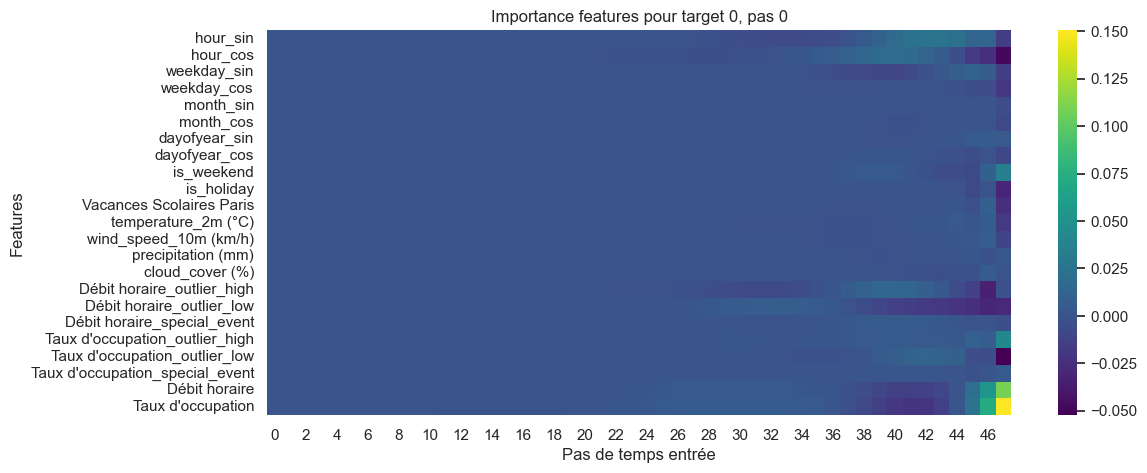

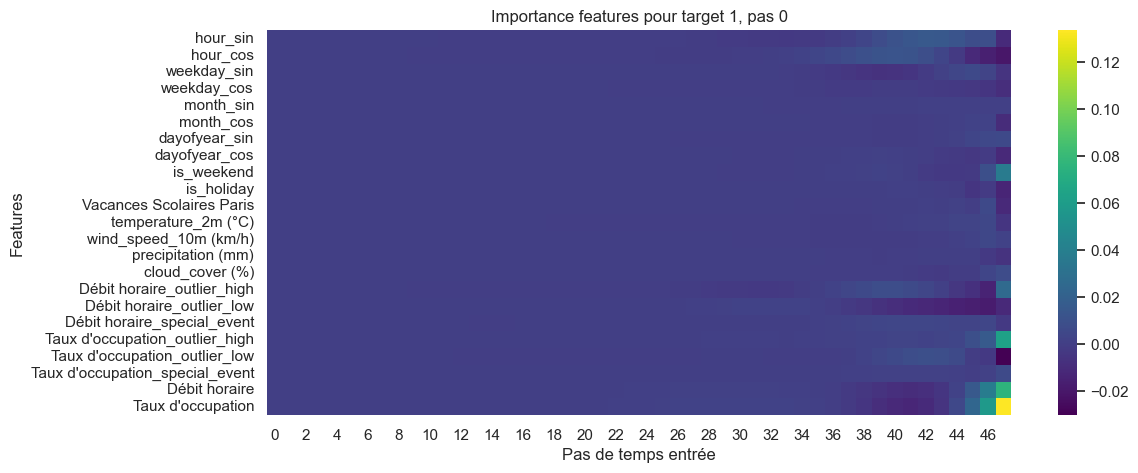

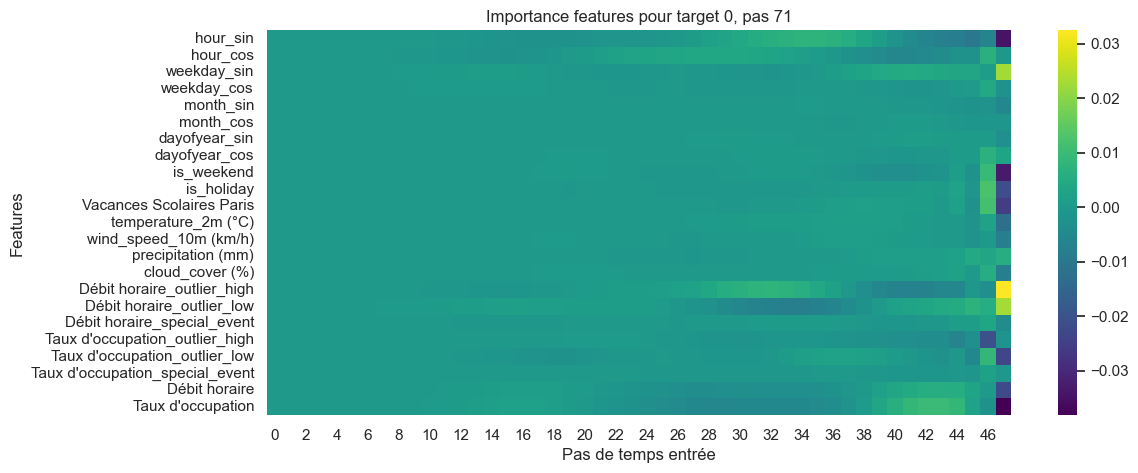

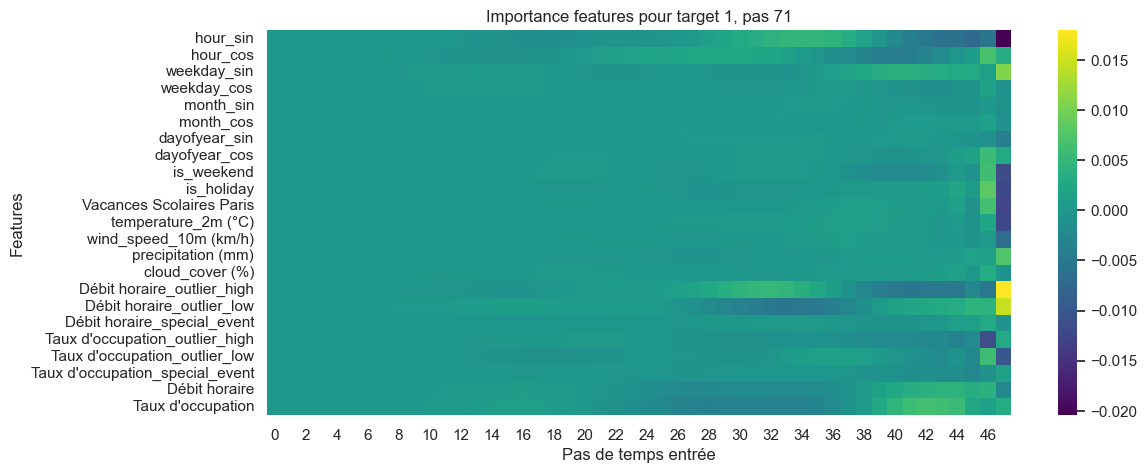

In [23]:
def plot_gradients_heatmap(gradients, begin,end,pred_length=None, n_targets=None, feature_names=None):
    """
    Trace des heatmaps des gradients (importance features -> sortie)
    """
    pred_length = gradients.shape[0] if pred_length is None else pred_length
    n_targets = gradients.shape[1] if n_targets is None else n_targets
    seq_length = gradients.shape[2]
    n_features = gradients.shape[3]

    for t in range(begin-1,end):
        for target_idx in range(n_targets):
            plt.figure(figsize=(12,5))
            sns.heatmap(gradients[t, target_idx, -48:, :].T, cmap="viridis")
            plt.xlabel("Pas de temps entrée")
            plt.ylabel("Features")
            if feature_names:
                plt.yticks(np.arange(n_features)+0.5, feature_names)
            plt.title(f"Importance features pour target {target_idx}, pas {t}")
            plt.show()
            
feature_names = features + targets
plot_gradients_heatmap(gradients, begin=1,end=1,feature_names=feature_names)
plot_gradients_heatmap(gradients, begin=72,end=72,feature_names=feature_names)



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import tensorflow as tf
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

import numpy as np
explainer = IntegratedGradients()

# Fonction de sortie : choisit un pas de sortie et une target
def model_output(input_tensor):
    preds = model(input_tensor)
    return preds[:, 0, 0]  # 1er pas, 1ère target

saliency = Saliency(model, model_modifier=None, clone=True)

# Premier échantillon
input_sample = X_test[0:1]

# Calcul des gradients
saliency_map = saliency(model_output, input_sample)

# Normalisation pour visualisation
saliency_map = normalize(saliency_map)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.heatmap(saliency_map[0].T, cmap="coolwarm")
plt.xlabel("Pas de temps entrée")
plt.ylabel("Features")
plt.title("Importance features pour target 0, pas 0")
plt.show()



InvalidArgumentError: Exception encountered when calling LSTMCell.call().

[1m{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [1,2], In[1]: [23,256] [Op:MatMul] name: [0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(1, 2), dtype=float32)
  • states=('tf.Tensor(shape=(1, 64), dtype=float32)', 'tf.Tensor(shape=(1, 64), dtype=float32)')
  • training=False

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,0,0), seasonal_order=(0,0,0,0)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_ = None
        
    def fit(self, X, y):
        # SARIMAX accepte exogènes
        self.model_ = sm.tsa.statespace.SARIMAX(
            y,
            exog=X,
            order=self.order,
            seasonal_order=self.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        return self
    
    def predict(self, X):
        return self.model_.predict(start=0, end=len(X)-1, exog=X)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


pipeline = Pipeline([
    ('sarimax', SARIMAXWrapper(order=(3,0,3), seasonal_order=(1,0,2,168)))
])


In [ ]:
import numpy as np
from sklearn.metrics import root_mean_squared_error

# Colonnes exexog = df[exog_cols]
target = 'Débit horaire'

# Taille du training set
n_train = len(df) - 120

# Split train/test
train_endog = df[target][7000:n_train]
test_endog = df[target][n_train:]
train_exog = exog[7000:n_train]
test_exog = exog[n_train:]

# Entraînement du pipeline
pipeline.fit(train_exog, train_endog)

# Prédiction sur le test set
y_pred = pipeline.predict(test_exog)

# Calcul du RMSE
rmse = root_mean_squared_error(test_endog, y_pred)

print(f"RMSE sur le test set: {rmse}")


c:\Users\marce\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\marce\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 